In [89]:
!pip install transformers

In [90]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [91]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [92]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

In [93]:
#@title create dataset


target_mean = [0.485, 0.456, 0.406]
target_std = [0.229, 0.224, 0.225]
processor = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=target_mean, std=target_std)])

class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")
        # self.segmentation_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/segmentations/'
        self.segmentation_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/segmentations/'

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    # def __getitem__(self, index):

    #     y = self.labels.iloc[index, 1] - 1
    #     file_name = self.filenames.iloc[index, 1]

    #     mask = np.array(Image.open(''.join([self.segmentation_path, file_name.split('.')[0], '.', file_name.split('.')[1], '.png'])).resize((224, 224)))

    #     x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
    #     x = processor(x)

    #     return x, y, (mask >= 1.0) * np.ones_like(mask)
    
    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(x)

        return x, y


class Prototype_Dataset(Dataset):
    def __init__(self, base_path, file_names, labels, train=True):

        self.base_path = base_path

        self.labels = labels
        self.file_names = file_names
        # self.segmentation_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/segmentations/'
        self.segmentation_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/segmentations/'

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        y = self.labels[index]
        file_name = self.file_names[index]

        mask = np.array(Image.open(''.join([self.segmentation_path, file_name.split('.')[0], '.', file_name.split('.')[1], '.png'])).resize((224, 224)))

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(x)

        return x, y, (mask >= 1.0) * np.ones_like(mask)


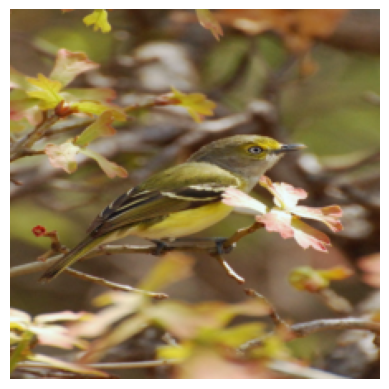

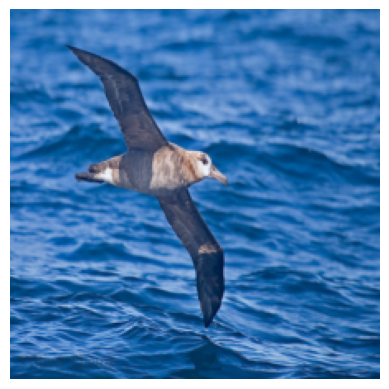

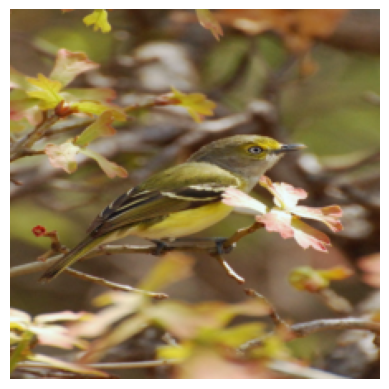

0 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/183.Northern_Waterthrush/Northern_Waterthrush_0023_177002.jpg
1 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0058_796074.jpg
2 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/156.White_eyed_Vireo/White_Eyed_Vireo_0112_159147.jpg


In [94]:
#@title dataset and dataloader and load a random query from test set

import random
from detectron2.data.detection_utils import read_image

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
base_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/'

inputs, labels = [], []
test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

random.seed(29)
data_indices = random.sample(range(test_dataset.__len__()), 1)
data_indices.insert(0, 29)
data_indices.insert(0, 5275)
for counter, data_idx in enumerate(data_indices):

  # query, query_label, query_mask = test_dataset.__getitem__(data_idx)
  query, query_label = test_dataset.__getitem__(data_idx)
  inputs.append(query)
  labels.append(query_label)

plt.figure(1)
plt.imshow(imsc(query))
plt.axis('off')
plt.show()

plt.figure(2)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.show()

plt.figure(3)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.show()

# The image initializations in VLPart is different. We need to use read_image function
vlpart_inputs = []
file_inputs = []
for counter, data_idx in enumerate(data_indices):
    # print(counter,data_idx)
    vlpart_x = ''.join([base_path, 'images/', test_dataset.filenames.iloc[data_idx, 1]])
    image_path = ''.join([base_path, 'images/', test_dataset.filenames.iloc[data_idx, 1]])
    file_inputs.append(image_path)
    print(counter,vlpart_x)
    vlpart_x = read_image(''.join([base_path, 'images/', test_dataset.filenames.iloc[data_idx, 1]]), format="BGR")
    vlpart_inputs.append(vlpart_x)

In [95]:
import glob
import multiprocessing as mp
import numpy as np
import os
import tempfile
import time
import warnings
import cv2
import tqdm
import argparse

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
import sys
from VLPart.vlpart.config import add_vlpart_config
from VLPart.demo.predictor import VisualizationDemo
from detectron2.config import CfgNode

DEFAULT_CONFIG_FILE = "/mnt/d/Github/SuperpixelCUB/VLPart/configs/pascal_part/r50_pascalpart.yaml"
DEFAULT_WEIGHTS = "/mnt/d/Github/SuperpixelCUB/VLPart/checkpoints/r50_pascalpart.pth"
DEFAULT_CONFIDENCE_THRESHOLD = 0.7
# CUSTOM_VOCABULARY =  ["bird beak", "bird head", "bird eye","bird leg", "bird foot", "bird wing", "bird neck", "bird tail","bird torso" ]
# CUSTOM_VOCABULARY = ["bird:back", "bird:head", "bird:foot", "bird:neck", "bird:beak", "bird:belly", "bird:breast", "bird:crown", "bird:eye", "bird:wing", "bird:nape", "bird:leg", "bird:torso", "bird:tail"]
CUSTOM_VOCABULARY = "bird back, bird head, bird foot, bird neck, bird beak, bird belly, bird breast, bird crown, bird eye, bird wing, bird nape, bird leg, bird torso, bird tail"
DEFAULT_OUTPUT_PATH = "/mnt/d/Github/SuperpixelCUB/output/"

def get_parser():
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument(
        "--input",
        nargs="+",
        help="A list of space separated input images; "
        "or a single glob pattern such as 'directory/*.jpg'",
    )
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )
    parser.add_argument(
        "--vocabulary",
        default="pascal_part",
        choices=['pascal_part', 'partimagenet', 'paco',
                 'voc', 'coco', 'lvis',
                 'pascal_part_voc', 'lvis_paco', 'custom'],
        help="",
    )
    parser.add_argument(
        "--custom_vocabulary",
        default="",
        help="",
    )
    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.5,
        help="Minimum score for instance predictions to be shown",
    )

    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    return parser


def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_vlpart_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.MODEL.WEIGHTS = DEFAULT_WEIGHTS
    cfg.merge_from_list(['VIS.BOX', 'False'])
    # cfg.merge_from_list(args.opts)
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = DEFAULT_CONFIDENCE_THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = DEFAULT_CONFIDENCE_THRESHOLD
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = DEFAULT_CONFIDENCE_THRESHOLD
    cfg.freeze()
    return cfg

mp.set_start_method("spawn", force=True)
args = get_parser().parse_args([])
args.config_file = DEFAULT_CONFIG_FILE
# args.custom_vocabulary = CUSTOM_VOCABULARY
# args.vocabulary = "custom"
args.confidence_threshold  = DEFAULT_CONFIDENCE_THRESHOLD
setup_logger(name="fvcore")
logger = setup_logger()
logger.info("Arguments: " + str(args))
cfg = setup_cfg(args)


[03/30 22:40:53 detectron2]: Arguments: Namespace(config_file='/mnt/d/Github/SuperpixelCUB/VLPart/configs/pascal_part/r50_pascalpart.yaml', webcam=False, video_input=None, input=None, output=None, vocabulary='pascal_part', custom_vocabulary='', confidence_threshold=0.7, opts=[])


In [96]:
from VLPart.demo.predictor import VisualizationDemo
from detectron2.data.detection_utils import read_image
from detectron2.utils.visualizer import ColorMode, Visualizer, GenericMask
from collections import defaultdict
from detectron2.data import MetadataCatalog

def get_class_names(dataset_name):
    class_names_dict = {}
    if dataset_name == "custom":
        for i, name in enumerate(CUSTOM_VOCABULARY.split(",")):
            class_names_dict[i] = name.strip()
    else:
        # Load the metadata for the dataset
        class_names_dict = {}
        metadata = MetadataCatalog.get(dataset_name)
        for i, name in enumerate(metadata.thing_classes):
            class_names_dict[i] = name       
    # print("class names:", class_names_dict)
    return class_names_dict

def refine_masks_by_semantics(semantic_groups, score_threshold=0.5):
    refined_masks = {}

    for label, mask_score_list in semantic_groups.items():
        # Sort masks by confidence descending
        sorted_masks = sorted(mask_score_list, key=lambda x: x[1], reverse=True)

        refined_mask = np.zeros_like(sorted_masks[0][0], dtype=np.uint8)
        confidence_map = np.zeros_like(refined_mask, dtype=np.float32)

        for mask, score in sorted_masks:
            if score < score_threshold:
                continue  # Skip low-confidence masks

            # Update only pixels with higher score than existing ones
            update_pixels = (mask & (score > confidence_map))
            refined_mask[update_pixels] = 1
            confidence_map[update_pixels] = score

        refined_masks[label] = refined_mask

    return refined_masks

def process_images(cfg):
    
    vlpart_refined_masks = []
    demo = VisualizationDemo(cfg)
    # for input_img in tqdm.tqdm(vlpart_inputs):
    for i, (input_img, file_path) in enumerate(zip(vlpart_inputs, file_inputs)):
        # img = read_image(path, format="BGR")
        start_time = time.time()
        predictions, visualized_output = demo.run_on_image(input_img)
        
        basename = os.path.splitext(os.path.basename(file_path))[0]
        print("basename:", basename)
        # create a folder for the current image
        output_dir = os.path.join(DEFAULT_OUTPUT_PATH, basename)
        os.makedirs(output_dir, exist_ok=True)

        if "instances" in predictions:
            pred_instances = predictions["instances"]
            pred_masks = pred_instances.pred_masks.to("cpu").numpy()
            pred_classes = pred_instances.pred_classes.to("cpu").numpy()
            pred_scores = pred_instances.scores.to("cpu").numpy()
            
            semantic_groups = defaultdict(list)
            # vocabulary_dict = get_class_names("custom")
            vocabulary_dict = get_class_names("pascal_part_val")
            
            for mask, cls, score in zip(pred_masks, pred_classes, pred_scores):
                pred_label = vocabulary_dict.get(cls, f"class_{cls}")
                semantic_groups[pred_label].append((mask, score))

            refined_masks = refine_masks_by_semantics(semantic_groups, score_threshold=0.55)
            
            vlpart_refined_masks.append(refined_masks)
            # save refined masks separately per semantic class
            for label, refined_mask in refined_masks.items():
                mask_img = (refined_mask * 255).astype(np.uint8)
                mask_filename = os.path.join(output_dir, f"{basename}_{label}.png")
                cv2.imwrite(mask_filename, mask_img)

        # save the visualized output
        out_filename = os.path.join(output_dir, f"{basename}_vis.jpg")
        visualized_output.save(out_filename)
    
    return vlpart_refined_masks
        
vlpart_final_masks = process_images(cfg)


Freezing Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Freezing Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size

/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_lo

WARNING [03/30 22:40:55 fvcore.common.checkpoint]: Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.base.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.0.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.0.bn2.num_batches_tracked
backbone.bottom_up.base.layer1.0.bn3.num_batches_tracked
backbone.bottom_up.base.layer1.0.downsample.1.num_batches_tracked
backbone.bottom_up.base.layer1.1.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.1.bn2.num_batches_tracked
backbone.bottom_up.base.layer1.1.bn3.num_batches_tracked
backbone.bottom_up.base.layer1.2.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.2.bn2.num_batches_tracked
backbone.bottom_up.base.layer1.2.bn3.num_batches_tracked
backbone.bottom_up.base.layer2.0.bn1.num_batches_tracked
backbone.bottom_up.base.layer2.0.bn2.num_batches_tracked
backbone.bottom_up.base.layer2.0.bn3.num_batches_tracked
backbone.bottom_up.base.layer2.0.downsample.1.num_batches_tracked
backbone.bottom_up.

In [97]:
print("vlpart_final_masks:", vlpart_final_masks)
print("vlpart_final_masks length:", len(vlpart_final_masks))

def label_to_class_id(label, dataset):
    if dataset != "custom":
        # Load the metadata for the dataset
        metadata = MetadataCatalog.get(dataset)
        print("metadata thing classes:", metadata.thing_classes)
        # build a dictionary of class names with i start from 1
        # class_dict = {i: name for i, name in enumerate(metadata.thing_classes)}
        class_dict = {i: name for i, name in enumerate(metadata.thing_classes, start=1)}
        print("class_dict:", class_dict)
    else:
        class_dict = get_class_names("custom")
    
    # find the class ID based on the label
    class_id = next((idx for idx, name in class_dict.items() if name == label), None)
    
    if class_id is not None:
        return int(class_id)
    else:
        # if label is class_{number} format
        if "_" in label and label.split("_")[-1].isdigit():
            return int(label.split("_")[-1])
        
def get_class_dict(dataset_name):
    if dataset_name == "custom":
        class_dict = {i: name for i, name in enumerate(CUSTOM_VOCABULARY.split(","))}
    else:
        # Load the metadata for the dataset
        metadata = MetadataCatalog.get(dataset_name)
        class_dict = {i: name for i, name in enumerate(metadata.thing_classes)}
    return class_dict

def class_names_to_segmentation_masks(refined_masks):
    segmentation_maps = {}
    for label, mask in refined_masks.items():
        print("label:", label)
        # label = label_to_class_id(label, "custom")
        label = label_to_class_id(label, "pascal_part_val")
        print("label to class id:", label)
        segmentation_maps[label] = mask

    return segmentation_maps

# convert masks to segmentation maps
vlpart_final_segmentations = []
for i in range(len(vlpart_final_masks)):
    vlpart_final_segmentations.append(class_names_to_segmentation_masks(vlpart_final_masks[i]))


vlpart_final_masks: [{'bird:torso': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'bird:beak': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'bird:head': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'bird:leg': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'bird:foot': array([[0, 0, 0, ..., 0, 0, 0],
     

In [98]:
#@title load model and precomputed prototypes

from transformers import CLIPVisionModel, Dinov2Model, ViTMAEModel, ViTModel

#model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
model = Dinov2Model.from_pretrained("facebook/dinov2-base").to('cuda')
#model = ViTMAEModel.from_pretrained("facebook/vit-mae-large", attn_implementation="eager").to('cuda')
#model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", attn_implementation="eager").to('cuda')

# all_prototype_file_names = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_file_names.csv')['0'].values
# all_prototype_labels = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_labels.csv')['0'].values
# all_prototype_clf_tokens = torch.load('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_representation.pth').to('cuda')

all_prototype_file_names = pd.read_csv('/mnt/d/Github/SuperpixelCUB/csv_data/clip-vitp16_5_prototypes_file_names.csv')['0'].values
all_prototype_labels = pd.read_csv('/mnt/d/Github/SuperpixelCUB/csv_data/clip-vitp16_5_prototypes_labels.csv')['0'].values
all_prototype_clf_tokens = torch.load('/mnt/d/Github/SuperpixelCUB/csv_data/clip-vitp16_5_prototypes_representation.pth').to('cuda')

IMG_SIZE = 224
STRIDE = model.config.patch_size #model.get_submodule('embeddings').get_submodule('patch_embeddings').get_submodule('projection').stride[0]
PATCH_SIZE = model.config.patch_size
NUMBER_OF_PATCHES_X = NUMBER_OF_PATCHES_Y = int(IMG_SIZE / PATCH_SIZE)
LATENT_DIM = all_prototype_clf_tokens.shape[-1]

/tmp/ipykernel_4078/396111678.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_prototype_clf_tokens = torch.load('/mnt/d/Github/SuperpixelCUB/csv_data/clip-vitp16_5_

In [ ]:
#@title find closest prototypes

from torch.nn.functional import cosine_similarity

device = 'cuda'
NUMBER_OF_PROTOTYPES = 5 # try 3, 5, 10, 20 etc...

def get_k_closest_prototypes(model, query, prototype_clf_tokens):

    query_clf_token = model(query).pooler_output
    similarity = cosine_similarity(query_clf_token, prototype_clf_tokens)
    top_k_similar_prototypes_indices = torch.topk(similarity, NUMBER_OF_PROTOTYPES)[1]

    return [i.item() for i in top_k_similar_prototypes_indices]

def get_tokens(model, query):
    return model(query).last_hidden_state[:, 1:, :].numpy(force=True)

def get_prototype_tokens(top_k_indices, prototype_file_names, prototype_labels, model):

    top_k_prototypes = [prototype_file_names[i] for i in top_k_indices]
    top_k_labels = [prototype_labels[i] for i in top_k_indices]

    prototype_dataset = Prototype_Dataset(base_path, top_k_prototypes, top_k_labels)
    prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_labels), shuffle=False, num_workers=0)
    prototypes, labels, masks = next(iter(prototype_loader))
    prototypes = prototypes.to(device)

    tokens = get_tokens(model, prototypes.to(device))

    return tokens, prototypes, labels, masks.numpy(force=True)

indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)
print("prototype tokens shape:", prototype_tokens.shape)
print("prototypes shape:", prototypes.shape)
print("prototype labels:", prototype_labels)
print("prototype masks shape:", prototype_masks.shape)

prototype tokens shape: (5, 256, 768)
prototypes shape: torch.Size([5, 3, 224, 224])
prototype labels: tensor([ 82, 143, 190, 138,  68])
prototype masks shape: (5, 224, 224)


In [113]:
#@title functions for getting segments and keypoints in image

from skimage.segmentation import slic, expand_labels
from skimage.transform import resize
from skimage.measure import regionprops

def get_segments(embedding, mask, number_of_patches: int,
                 resize_size: int = 64, number_of_segments: int = 8):

    embedding = embedding.reshape(number_of_patches, number_of_patches, -1)
    embedding = resize(embedding, (resize_size, resize_size))

    mask = resize(mask, (resize_size, resize_size), order=0)

    segments = slic(embedding, n_segments=number_of_segments, mask=mask)

    return segments

def get_segments_from_vlpart(image_inputs: dict, resize_size: int = 64):

    result = []
    for part_label, mask in image_inputs.items():
        resized_segment = resize(mask, (resize_size, resize_size), order=0, preserve_range=True).astype(np.uint8)
        result.append({'label': part_label, 'segmentation': resized_segment})
    return result


def get_keypoints(segments, resize_size: int = 64, image_size: int = 224):

    low_res_keypoints = np.zeros_like(segments)
    low_res_segments_properties = regionprops(segments)

    for segment_i, properties_i in enumerate(low_res_segments_properties):
        x_coordinate, y_coordinate = np.int32(np.round(properties_i.centroid))
        low_res_keypoints[x_coordinate, y_coordinate] = segment_i+1

    keypoints = np.zeros((image_size, image_size), dtype=np.int32)

    high_res_keypoints = resize(low_res_keypoints, (image_size, image_size), order=0)
    segments_properties = regionprops(high_res_keypoints)

    for segment_i, properties_i in enumerate(segments_properties):
        x_coordinate, y_coordinate = np.int32(np.round(properties_i.centroid))
        keypoints[x_coordinate, y_coordinate] = segment_i+1

    return keypoints

def get_keypoints_from_vlpart(input_segments, resize_size: int = 64, image_size: int = 224):

    # convert segments_dict to single 2D array
    segments = np.zeros_like(next(iter(input_segments.values())), dtype=np.int32)
    for label, mask in input_segments.items():
        # print("label:", label)
        segments[mask.astype(bool)] = label  
    
    segments = resize(segments, (resize_size, resize_size), order=0, preserve_range=True).astype(np.int32)

    low_res_keypoints = np.zeros_like(segments, dtype=np.int32)
    props = regionprops(segments)

    for region_i, prop_i in enumerate(props):
        x_coordinate, y_coordinate = np.int32(np.round(prop_i.centroid))
        low_res_keypoints[x_coordinate, y_coordinate] = region_i + 1

    keypoints = np.zeros((224, 224), dtype=np.int32)

    high_res_keypoints = resize(low_res_keypoints, (224, 224), order=0, preserve_range=True)
    props = regionprops(high_res_keypoints.astype(np.int32))

    for region_i, prop_i in enumerate(props):
        x_coordinate, y_coordinate = np.int32(np.round(prop_i.centroid))
        keypoints[x_coordinate, y_coordinate] = region_i + 1


In [114]:
#@title find all keypoints in each image

all_keypoints = []
all_segments = []
vlpart_final_masks
embeddings = np.concatenate((get_tokens(model, query.to(device).unsqueeze(0)), prototype_tokens))
# masks = np.concatenate((query_mask[None, :, :], prototype_masks))

# for embedding, mask in zip(embeddings, masks):
#     all_segments.append(get_segments(embedding, mask, NUMBER_OF_PATCHES_X))

for mask in vlpart_final_segmentations:
    all_segments.append(get_segments_from_vlpart(mask, resize_size=64))

# for segment_i in all_segments:
    # all_keypoints.append(get_keypoints(segment_i))

for segment_i in vlpart_final_segmentations:
    all_keypoints.append(get_keypoints_from_vlpart(segment_i))

In [115]:
#@title function for getting segment representation

def get_segment_representation(segments, embedding, number_of_patches: int,
                               latent_dimensionality: int, resize_size: int = 64):

    segment_representations = []

    embedding = embedding.reshape(number_of_patches, number_of_patches, -1)
    embedding = resize(embedding, (resize_size, resize_size)).reshape(-1, latent_dimensionality)

    for segment_i in np.unique(segments)[1:]:
        segment_i_indices = np.where(segments.flatten()==segment_i)[0]
        segment_representations.append(np.mean(embedding[segment_i_indices], 0, keepdims=True))

    return np.concatenate(segment_representations), len(np.unique(segments)[1:])

def get_segment_representation_vlpart(segments, embedding, number_of_patches: int,
                               latent_dimensionality: int, resize_size: int = 64):
    segment_representations = []

    embedding = embedding.reshape(number_of_patches, number_of_patches, -1)
    embedding = resize(embedding, (resize_size, resize_size), order=1, preserve_range=True)
    embedding = embedding.reshape(-1, latent_dimensionality)

    for part in segments:
        mask = part['segmentation'].astype(bool)
        flat_indices = np.where(mask.flatten())[0]

        if len(flat_indices) == 0:
            continue  

        mean_representation = np.mean(embedding[flat_indices], axis=0, keepdims=True)
        segment_representations.append(mean_representation)

    if len(segment_representations) == 0:
        return np.empty((0, latent_dimensionality)), 0

    return np.concatenate(segment_representations, axis=0), len(segment_representations)


In [106]:
#@title find mean representation of each region

all_segments_representation = []
number_of_segments = []
print("all_segments:", all_segments)
for segment, embedding in zip(all_segments, embeddings):
    # segments_representation, number_of_segments_i = get_segment_representation(segment, embedding, NUMBER_OF_PATCHES_X, LATENT_DIM)
    segments_representation, number_of_segments_i = get_segment_representation_vlpart(segment, embedding, NUMBER_OF_PATCHES_X, LATENT_DIM)
    all_segments_representation.append(segments_representation)
    number_of_segments.append(number_of_segments_i)


all_segments: [[{'label': 16, 'segmentation': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}, {'label': 8, 'segmentation': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}, {'label': 9, 'segmentation': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}, {'label': 11, 'segmentation': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], d

In [116]:
#@title function for getting mutual nns

def get_mutual_nns(representations: torch.Tensor, number_of_segments: List):

    query_representation = representations[0]
    prototype_representations = np.concatenate(representations[1:])

    nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(query_representation, prototype_representations, axis=1, metric='cosine')
    nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(query_representation, prototype_representations, axis=0, metric='cosine')

    best_buddies_query = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(number_of_segments[0])
    best_buddies_prototypes = nearest_neighbor_query[nearest_neighbor_prototypes] == np.arange(np.sum(number_of_segments[1:]))

    #best_buddies_query_indices = nearest_neighbor_query[best_buddies_query]
    #best_buddies_prototypes_indices = nearest_neighbor_prototypes[best_buddies_prototypes]

    return best_buddies_query, best_buddies_prototypes, nearest_neighbor_query, nearest_neighbor_prototypes

In [117]:
#@title find mutual nns

best_buddies_query, best_buddies_prototypes, nearest_neighbor_query, nearest_neighbor_prototypes = get_mutual_nns(all_segments_representation, number_of_segments)
print("best_buddies_query:", best_buddies_query)
print("best_buddies_prototypes:", best_buddies_prototypes)


best_buddies_query: [ True False False False False False]
best_buddies_prototypes: [ True False False False False False False False False False]


In [122]:
#@title function for making prediction

def get_prediction(prototype_matches, prototype_labels, number_of_segments: List, number_of_prototypes: int = 5):

    number_of_matches = []
    for number_of_segments_index in range(len(number_of_segments)-1):
        lower_bound = np.int32(np.sum(number_of_segments[:number_of_segments_index]))
        upper_bound = np.int32(np.sum(number_of_segments[:(number_of_segments_index+1)]))
        number_of_matches.append(np.sum(prototype_matches[lower_bound:upper_bound]))

    number_of_matches = np.array(number_of_matches)
    total_number_of_matches = np.sum(number_of_matches)
    predictions = {}

    for label_i in torch.unique(prototype_labels):
        label_indices = np.where(label_i == prototype_labels)[0]
        predictions[label_i.item()] = np.sum(number_of_matches[label_indices]) / total_number_of_matches

    return predictions

print("best_buddies_prototypes:", best_buddies_prototypes)
print("prototype_labels:", prototype_labels)
print("number_of_segments:", number_of_segments)
predictions = get_prediction(best_buddies_prototypes, prototype_labels, number_of_segments)
prediction = max(predictions, key=predictions.get)
print(predictions, prediction)

best_buddies_prototypes: [ True False False False False False False False False False]
prototype_labels: tensor([ 82, 143, 190, 138,  68])
number_of_segments: [6, 5, 5]


IndexError: index 4 is out of bounds for axis 0 with size 2

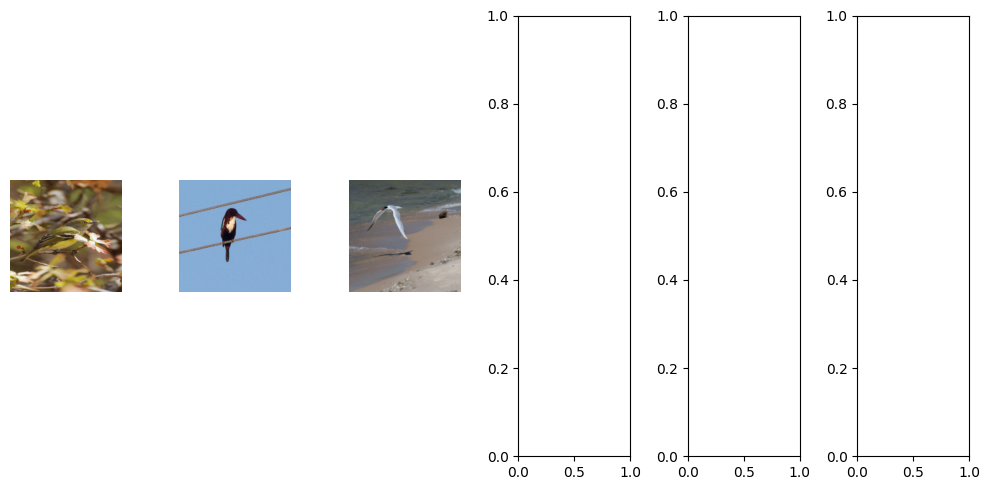

In [123]:
#@title plot matching keypoints

color_names = ["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                    "maroon", "black", "white", "chocolate", "gray", "blueviolet"]
cmap = ListedColormap(color_names)

colors = np.array([cmap(x) for x in range(15)])
mnn_matches = {}

fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES+1, figsize=(10, 5))

inputs = torch.cat([query.to(device).unsqueeze(0), prototypes])

for col_idx, (image_i, keypoints_i) in enumerate(zip(inputs, all_keypoints)):

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    radius1, radius2 = 8, 1

    for keypoint_counter, keypoint_i in enumerate(np.unique(keypoints_i)[1:]):

        if col_idx == 0:
          if not best_buddies_query[keypoint_i-1]: continue
        elif col_idx == 1:
          if not best_buddies_prototypes[keypoint_i-1]: continue
        else:
          if not best_buddies_prototypes[np.sum(number_of_segments[:col_idx-1])+keypoint_i-1]: continue

        if col_idx == 0:
          color_value = keypoint_counter
          mnn_matches[keypoint_i-1] = color_value
        elif col_idx == 1:
          color_value = mnn_matches[nearest_neighbor_prototypes[keypoint_i-1]]
        else:
          color_value = mnn_matches[nearest_neighbor_prototypes[np.sum(number_of_segments[:col_idx-1])+keypoint_i-1]]

        y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

        circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=colors[color_value], edgecolor='white')
        axs[col_idx].add_patch(circ1_1)
        axs[col_idx].add_patch(circ1_2)


fig.tight_layout()

In [124]:
labels_with_matches = {label_i.item():0 for label_i in torch.unique(prototype_labels)}
number_of_label_matches = {label_i.item():0 for label_i in torch.unique(prototype_labels)}
prototypes_with_matches = {}

for prototype_count, (keypoints_i, prototype_label) in enumerate(zip(all_keypoints[1:], prototype_labels)):
    number_of_matches = 0
    for keypoint_i in np.unique(keypoints_i)[1:]:

        if prototype_count == 0:
          if not best_buddies_prototypes[keypoint_i-1]: continue
        else:
          if not best_buddies_prototypes[np.sum(number_of_prototype_regions[:(prototype_count)])+keypoint_i-1]: continue

        labels_with_matches[prototype_label.item()] += 1
        number_of_matches += 1

        if number_of_matches > 0:
          number_of_label_matches[prototype_label.item()] += 1

    if number_of_matches > 0:
      prototypes_with_matches[prototype_count] = 1

total_number_of_matches = sum(labels_with_matches.values())
labels_with_matches = {k: v for k, v in sorted(labels_with_matches.items(), key=lambda item: item[1], reverse=True)}

print(total_number_of_matches)
print(labels_with_matches)
print(prototypes_with_matches)
print(number_of_label_matches)

0
{68: 0, 82: 0, 138: 0, 143: 0, 190: 0}
{}
{68: 0, 82: 0, 138: 0, 143: 0, 190: 0}


In [ ]:

number_of_rows = len(labels_with_matches)
number_of_columns = max(number_of_label_matches.values()) + 1

fig, axs = plt.subplots(number_of_rows, number_of_columns, figsize=(3*number_of_columns, 3*number_of_rows), squeeze=False)

axs[0, 0].set_title('Query')
for ax in axs.ravel(): ax.set_axis_off()

for row_idx, label_i in enumerate(labels_with_matches.keys()):

    axs[row_idx, 0].imshow(imsc(inputs[0]))

    indices_of_labels = list(np.where((prototype_labels == label_i))[0])

    for label_index in indices_of_labels:
        if not label_index in list(prototypes_with_matches.keys()):
            indices_of_labels.remove(label_index)

    indices_of_labels = [index_of_label+1 for index_of_label in indices_of_labels]

    span_of_indices_of_lables = []
    for index_of_label in indices_of_labels:
        upper_bound = np.sum(number_of_prototype_regions[:(index_of_label)])
        lower_bound = upper_bound-np.sum(number_of_prototype_regions[(index_of_label-1):(index_of_label)])

        for i in range(lower_bound, upper_bound):
            span_of_indices_of_lables.append(i)

    indices_of_labels.insert(0, 0)

    all_keypoints_row_i = [all_keypoints[i] for i in indices_of_labels]

    for col_idx, (index_of_label, keypoints_i) in enumerate(zip(indices_of_labels, all_keypoints_row_i)):

        axs[row_idx, col_idx].imshow(imsc(inputs[index_of_label]))
        axs[row_idx, col_idx].set_axis_off()

        radius1, radius2 = 8, 1

        for keypoint_counter, keypoint_i in enumerate(np.unique(keypoints_i)[1:]):

            if index_of_label == 0:
              if not best_buddies_query[keypoint_i-1]: continue
            elif index_of_label == 1:
              if not best_buddies_prototypes[keypoint_i-1]: continue
            else:
              if not best_buddies_prototypes[np.sum(number_of_prototype_regions[:(index_of_label-1)])+keypoint_i-1]: continue

            if index_of_label == 0 and not nearest_neighbor_query[keypoint_i-1] in span_of_indices_of_lables: continue

            if index_of_label == 0:
              color_value = keypoint_counter
              mnn_matches[keypoint_i-1] = color_value
            elif index_of_label == 1:
              color_value = mnn_matches[nearest_neighbor_prototypes[keypoint_i-1]]
            else:
              color_value = mnn_matches[nearest_neighbor_prototypes[np.sum(number_of_prototype_regions[:(index_of_label-1)])+keypoint_i-1]]

            y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

            circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
            circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=colors[color_value], edgecolor='white')
            axs[row_idx, col_idx].add_patch(circ1_1)
            axs[row_idx, col_idx].add_patch(circ1_2)


In [ ]:
#@title Evaluate on test set

import random

base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

random.seed(31)
data_indices = random.sample(range(test_dataset.__len__()), 1000)
hits = []

for counter, data_idx in enumerate(data_indices):

    query, query_label, query_mask = test_dataset.__getitem__(data_idx)

    indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
    prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)

    all_keypoints = []
    all_segments = []

    embeddings = np.concatenate((get_tokens(model, query.to(device).unsqueeze(0)), prototype_tokens))
    masks = np.concatenate((query_mask[None, :, :], prototype_masks))

    for embedding, mask in zip(embeddings, masks):
      all_segments.append(get_segments(embedding, mask, NUMBER_OF_PATCHES_X))

    for segment_i in all_segments:
      all_keypoints.append(get_keypoints(segment_i))

    all_segments_representation = []
    number_of_segments = []

    for segment, embedding in zip(all_segments, embeddings):
        segments_representation, number_of_segments_i = get_segment_representation(segment, embedding, NUMBER_OF_PATCHES_X, LATENT_DIM)
        all_segments_representation.append(segments_representation)
        number_of_segments.append(number_of_segments_i)

    best_buddies_query, best_buddies_prototypes, nearest_neighbor_query, nearest_neighbor_prototypes = get_mutual_nns(all_segments_representation, number_of_segments)

    predictions = get_prediction(best_buddies_prototypes, prototype_labels, number_of_segments)
    prediction = max(predictions, key=predictions.get)

    hits.append((prediction == query_label))

    print(counter, hits[-1], np.sum(hits)/len(hits))

In [ ]:
from torch.nn.functional import cosine_similarity

device = 'cuda'
NUMBER_OF_PROTOTYPES = 5

def get_k_closest_prototypes(model, query, prototype_clf_tokens):

    query_clf_token = model(query).pooler_output
    similarity = cosine_similarity(query_clf_token, prototype_clf_tokens)
    top_k_similar_prototypes_indices = torch.topk(similarity, NUMBER_OF_PROTOTYPES)[1]

    return [i.item() for i in top_k_similar_prototypes_indices]

def get_tokens(model, query):
    return model(query).last_hidden_state[:, 1:, :].numpy(force=True)

def get_prototype_tokens(top_k_indices, prototype_file_names, prototype_labels, model):

    top_k_prototypes = [prototype_file_names[i] for i in top_k_indices]
    top_k_labels = [prototype_labels[i] for i in top_k_indices]

    prototype_dataset = Prototype_Dataset(base_path, top_k_prototypes, top_k_labels)
    prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_labels), shuffle=False, num_workers=0)
    prototypes, labels, masks = next(iter(prototype_loader))
    prototypes = prototypes.to(device)

    tokens = get_tokens(model, prototypes.to(device))

    return tokens, prototypes, labels, masks.numpy(force=True)

indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)

In [ ]:
#@title keypoint counting classifier class

import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass
from typing import List, Tuple

def get_number_of_patches_and_dim(model: nn.Module, image_size: int) -> Tuple[int, int]:

    dummy_input = torch.zeros(1, 3, image_size, image_size, device='cuda')
    outputs = model(dummy_input)
    _, number_of_patches, token_dimensionality = outputs.last_hidden_state.shape
    return number_of_patches-1, token_dimensionality


@dataclass
class Keypoint_Counting_Classifier:
    vit: nn.Module
    prototype_clf_tokens: torch.Tensor
    number_of_prototypes: int
    number_of_classes: int
    image_size: int
    path_to_prototype_resources: str
    device: str='cuda'

    def __post_init__(self):

        self.vit.eval()
        self.vit = self.vit.to(self.device)

        self.number_of_patches, self.token_dimensionality = get_number_of_patches_and_dim(self.vit, self.image_size)

    def predict(self, query):

        query = query.unsqueeze(0).to(self.device)

        prototype_dict = self.prepare_prototypes(query)

    def predcit_and_viz(self):
        pass

    def prepare_prototypes(self, query):

        query_clf_token = self.vit(query).pooler_output
        similarity = cosine_similarity(query_clf_token, self.prototype_clf_tokens)
        top_k_similar_prototypes_indices = torch.topk(similarity, self.number_of_prototypes)[1]

        return None

kcc = Keypoint_Counting_Classifier(model, all_prototype_clf_tokens, 5, 200, 224, 'drive/MyDrive/CoSegXAI/')
out = kcc.predict(query)

In [ ]:
all_prototype_file_names = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_file_names.csv')['0'].values
all_prototype_labels = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_labels.csv')['0'].values
all_prototype_clf_tokens = torch.load('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_representation.pth').to('cuda')